## 01

In [1]:
!kaggle datasets download davinwijaya/customer-retention

100%|█████████████████████████████████████████| 433k/433k [00:00<00:00, 907kB/s]
100%|█████████████████████████████████████████| 433k/433k [00:00<00:00, 905kB/s]


In [2]:
!unzip customer-retention.zip

Archive:  customer-retention.zip
  inflating: data.csv                


## 02

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.viz import plot_uplift_curve, plot_uplift_preds

from catboost import CatBoostClassifier

In [4]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df = df.rename(columns={'offer': 'treatment', 'conversion': 'target'})
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
df['treatment'].value_counts()

treatment
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64

In [7]:
df['treatment'] = df['treatment'].replace(['Buy One Get One', 'Discount', 'No Offer'], [1, 1, 0])
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


## 03

In [8]:
x_train, x_test, y_train, y_test, treat_train, treat_test = train_test_split(
    df.drop(columns=['target', 'treatment']), df['target'], df['treatment'], random_state=42)

In [9]:
x_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
7517,6,92.45,0,1,Urban,0,Web
5343,1,796.97,0,1,Rural,1,Multichannel
35537,7,390.14,0,1,Urban,1,Phone
63983,2,83.03,0,1,Urban,0,Phone
45287,10,734.90,1,0,Rural,1,Multichannel


In [10]:
y_train.head()

7517     0
5343     0
35537    0
63983    0
45287    1
Name: target, dtype: int64

In [11]:
treat_train.head()

7517     0
5343     1
35537    1
63983    0
45287    1
Name: treatment, dtype: int64

## 04

In [12]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48000 entries, 7517 to 56422
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        48000 non-null  int64  
 1   history        48000 non-null  float64
 2   used_discount  48000 non-null  int64  
 3   used_bogo      48000 non-null  int64  
 4   zip_code       48000 non-null  object 
 5   is_referral    48000 non-null  int64  
 6   channel        48000 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.9+ MB


In [13]:
x_train['recency'].value_counts()

recency
1     6731
10    5658
2     5640
9     4833
3     4376
4     3791
6     3451
5     3424
7     3091
11    2638
8     2606
12    1761
Name: count, dtype: int64

In [14]:
x_train['history'].nunique()

28742

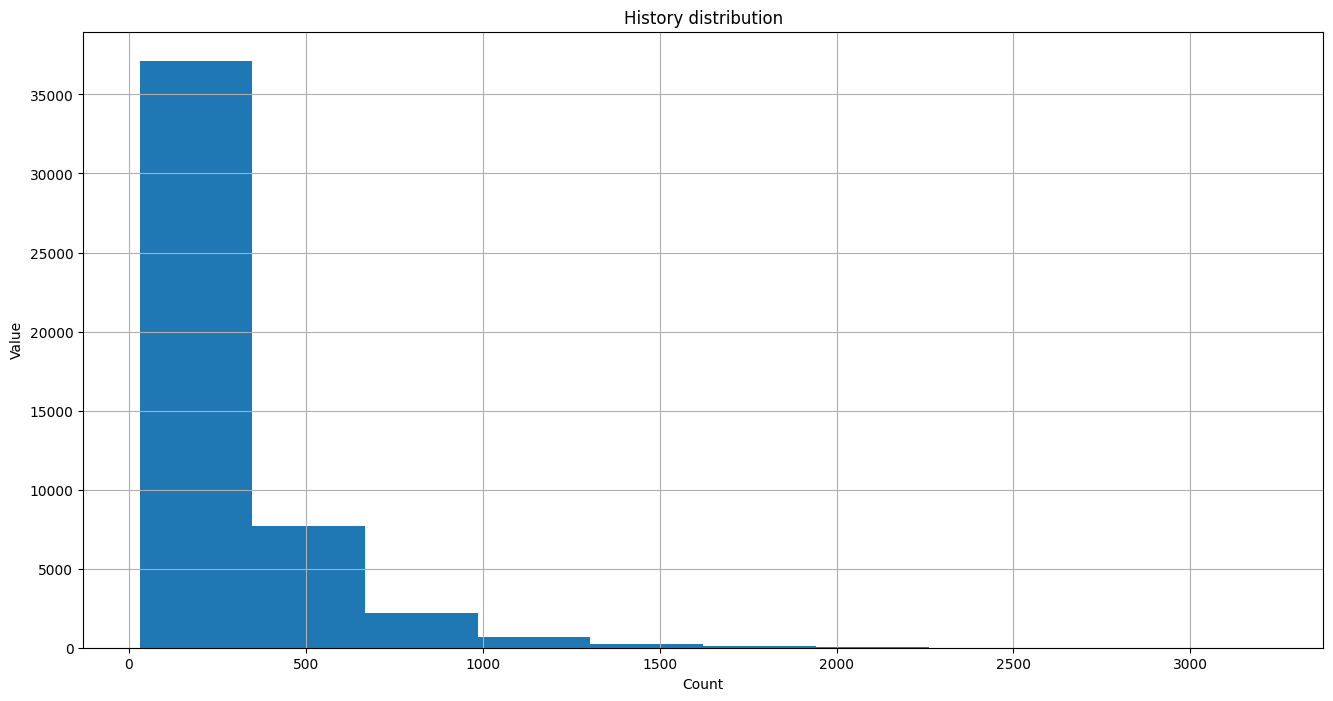

In [15]:
plt.figure(figsize=(16, 8))

x_train['history'].hist(bins=10)
plt.xlabel('Count')
plt.ylabel('Value')

plt.title('History distribution')
plt.show()

In [16]:
x_train['used_discount'].value_counts()

used_discount
1    26425
0    21575
Name: count, dtype: int64

In [17]:
x_train['used_bogo'].value_counts()

used_bogo
1    26433
0    21567
Name: count, dtype: int64

In [18]:
x_train['is_referral'].value_counts()

is_referral
1    24047
0    23953
Name: count, dtype: int64

In [19]:
x_train['zip_code'].value_counts()

zip_code
Surburban    21680
Urban        19149
Rural         7171
Name: count, dtype: int64

In [20]:
x_train['zip_code'] = x_train['zip_code'].replace(['Urban', 'Surburban', 'Rural'], [0, 1, 2])
x_test['zip_code'] = x_test['zip_code'].replace(['Urban', 'Surburban', 'Rural'], [0, 1, 2])

In [21]:
x_train['is_referral'].value_counts()

is_referral
1    24047
0    23953
Name: count, dtype: int64

In [22]:
x_train['channel'].value_counts()

channel
Web             21158
Phone           21046
Multichannel     5796
Name: count, dtype: int64

In [23]:
x_train['channel'] = x_train['channel'].replace(['Web', 'Phone', 'Multichannel'], [0, 1, 2])
x_test['channel'] = x_test['channel'].replace(['Web', 'Phone', 'Multichannel'], [0, 1, 2])

In [24]:
x_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
7517,6,92.45,0,1,0,0,0
5343,1,796.97,0,1,2,1,2
35537,7,390.14,0,1,0,1,1
63983,2,83.03,0,1,0,0,1
45287,10,734.90,1,0,2,1,2
...,...,...,...,...,...,...,...
62570,3,276.21,0,1,0,0,1
38158,4,43.49,0,1,0,0,1
860,8,492.53,1,1,2,1,1
15795,5,72.28,1,0,0,1,0


In [25]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 33042 to 27093
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        16000 non-null  int64  
 1   history        16000 non-null  float64
 2   used_discount  16000 non-null  int64  
 3   used_bogo      16000 non-null  int64  
 4   zip_code       16000 non-null  int64  
 5   is_referral    16000 non-null  int64  
 6   channel        16000 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1000.0 KB


## 05

In [26]:
cat_features = ['zip_code', 'channel']

pd.DataFrame.iteritems = pd.DataFrame.items

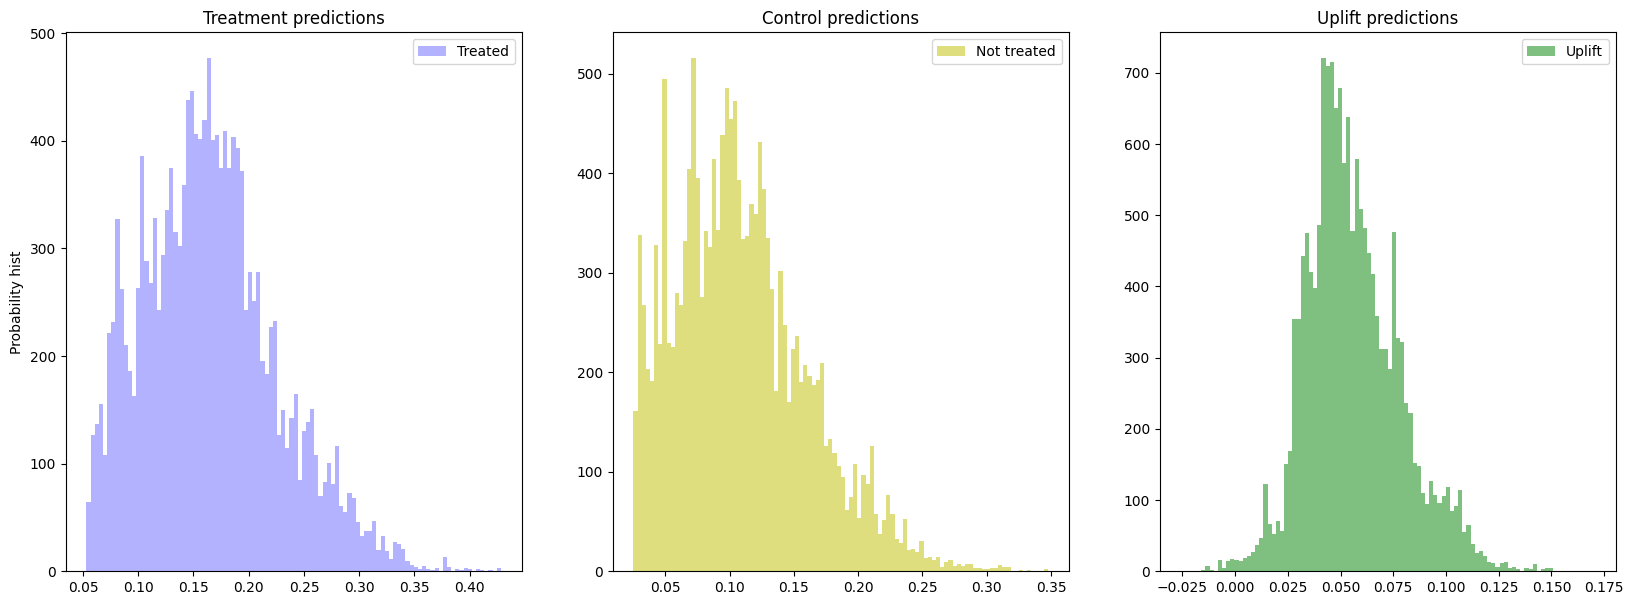

In [27]:
sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, 
                                  silent=True, cat_features=cat_features))

sm = sm.fit(x_train, y_train, treat_train)

uplift_sm = sm.predict(x_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, 
                          strategy='by_group', k=.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, 
                          strategy='by_group', k=.2)
sm_metrics = {'approach': 'Solo Model', 'uplift@10%': sm_score_10, 'uplift@20%': sm_score_20}

plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

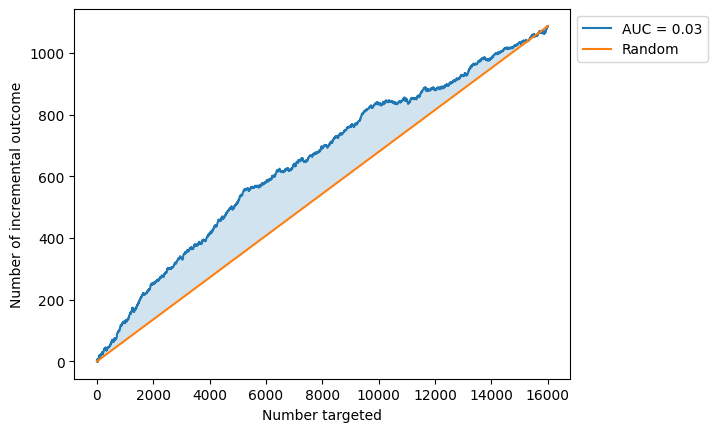

In [28]:
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False);

In [29]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, 
                                            cat_features=cat_features))
ct = ct.fit(x_train, y_train, treat_train)

uplift_ct = ct.predict(x_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, 
                          strategy='by_group', k=.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, 
                          strategy='by_group', k=.2)
ct_metrics = {'approach': 'Class Transformation', 'uplift@10%': ct_score_10, 
              'uplift@20%': ct_score_20}

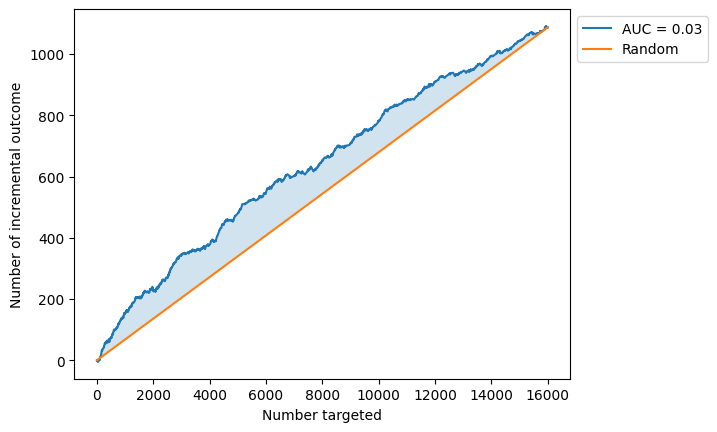

In [30]:
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False);

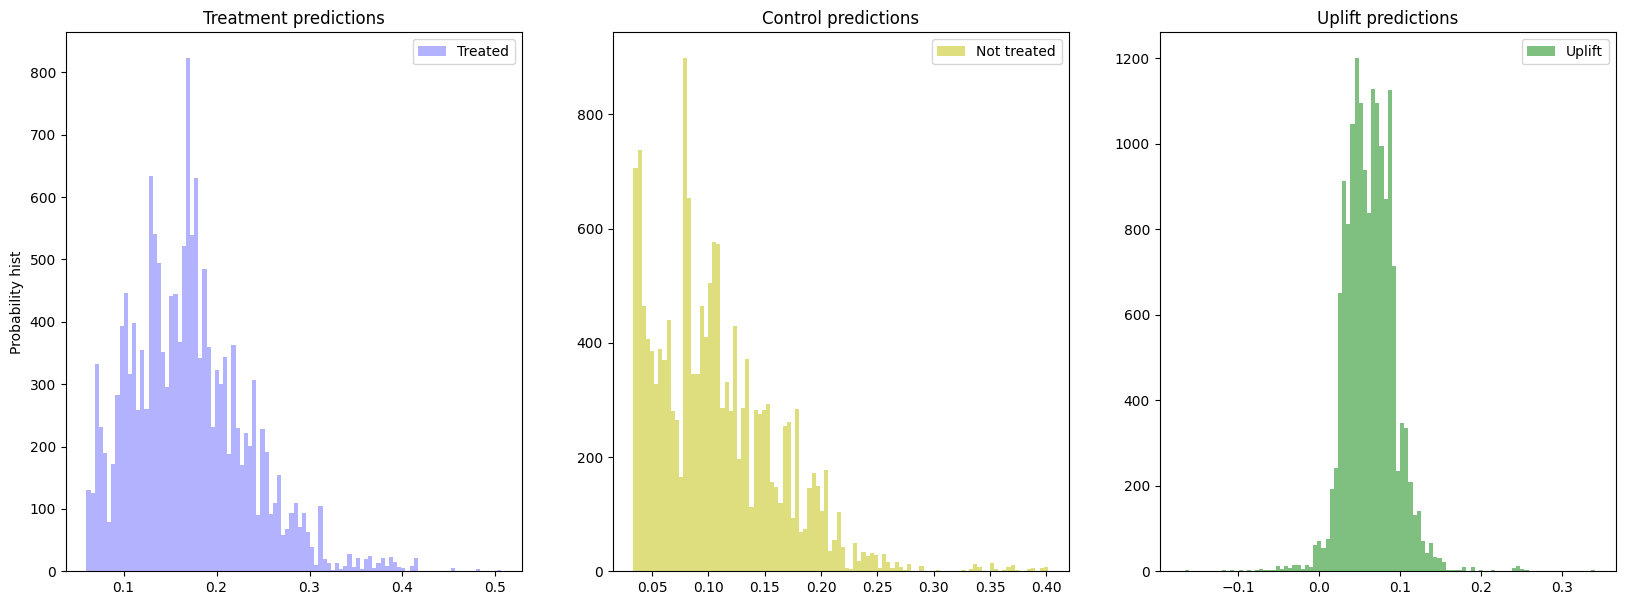

In [31]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features), 
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features), 
    method='vanilla')
tm = tm.fit(x_train, y_train, treat_train)

uplift_tm = tm.predict(x_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, 
                          strategy='by_group', k=.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, 
                          strategy='by_group', k=.2)
tm_metrics = {'approach': 'Two Independent Model', 'uplift@10%': tm_score_10, 
              'uplift@20%': tm_score_20}

tm_trmnt_preds = tm.trmnt_preds_
tm_ctrl_preds = tm.ctrl_preds_

plot_uplift_preds(trmnt_preds=tm_trmnt_preds, ctrl_preds=tm_ctrl_preds);

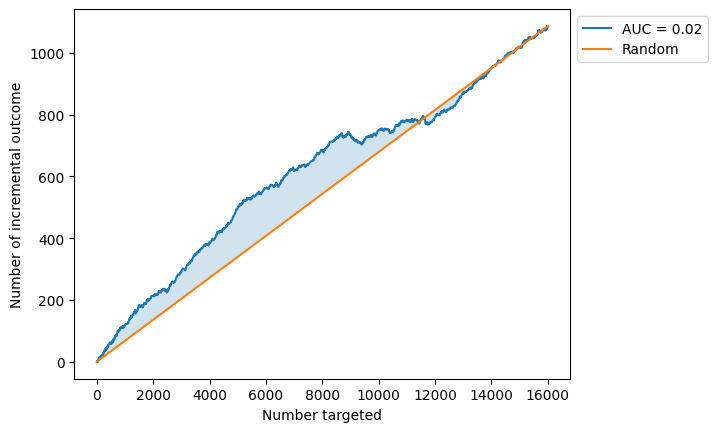

In [32]:
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False);

## 06

In [33]:
df_metrics = pd.DataFrame.from_records([sm_metrics, ct_metrics, tm_metrics])
df_metrics

,approach,uplift@10%,uplift@20%
0,Solo Model,0.135178,0.112432
1,Class Transformation,0.130616,0.109236
2,Two Independent Model,0.115410,0.095982


## 07

In [34]:
# Мы не смогли сделать часть домашнего задания при помощи библиотеки causalml, потому что она не
# работает. 

## 08

In [35]:
uplift_sm

array([0.03823428, 0.09231884, 0.07467323, ..., 0.05090824, 0.06461601,
       0.05011143])

In [36]:
deciles = pd.DataFrame({'y': y_test, 'uplift': uplift_sm}).sort_values('uplift', ascending=False)
deciles.head()

,y,uplift
52596,0,0.170652
26533,1,0.154139
38313,0,0.150892
5525,0,0.150892
27441,1,0.150892


In [37]:
deciles['deciles'] = pd.qcut(x=deciles['uplift'], q=10)
deciles.head()

,y,uplift,deciles
52596,0,0.170652,"(0.0852, 0.171]"
26533,1,0.154139,"(0.0852, 0.171]"
38313,0,0.150892,"(0.0852, 0.171]"
5525,0,0.150892,"(0.0852, 0.171]"
27441,1,0.150892,"(0.0852, 0.171]"


In [38]:
deciles_sum = deciles.groupby('deciles').sum()
deciles_sum = deciles_sum.rename(columns={'y': 'y_sum', 'uplift': 'uplift_sum'})
deciles_sum

,y_sum,uplift_sum
deciles,,
"(-0.0269, 0.0307]",177,35.117786
"(0.0307, 0.038]",168,54.899416
"(0.038, 0.0435]",192,65.806464
"(0.0435, 0.048]",219,73.441416
"(0.048, 0.053]",211,80.391455
"(0.053, 0.0586]",213,89.224931
"(0.0586, 0.0651]",241,98.709227
"(0.0651, 0.0746]",260,111.346924
"(0.0746, 0.0852]",267,126.610901


In [39]:
deciles_count = deciles.groupby('deciles').count()
deciles_count = deciles_count.rename(columns={'y': 'y_count', 'uplift': 'uplift_count'})
deciles_count

,y_count,uplift_count
deciles,,
"(-0.0269, 0.0307]",1603,1603
"(0.0307, 0.038]",1597,1597
"(0.038, 0.0435]",1602,1602
"(0.0435, 0.048]",1605,1605
"(0.048, 0.053]",1595,1595
"(0.053, 0.0586]",1602,1602
"(0.0586, 0.0651]",1599,1599
"(0.0651, 0.0746]",1597,1597
"(0.0746, 0.0852]",1603,1603


In [40]:
deciles_conversion = pd.concat([deciles_sum, deciles_count], axis=1)
deciles_conversion['conversion'] = deciles_conversion['y_sum'] / deciles_conversion['y_count']
deciles_conversion.sort_values('deciles', ascending=False)

,y_sum,uplift_sum,y_count,uplift_count,conversion
deciles,,,,,
"(0.0852, 0.171]",369,160.540967,1597,1597,0.231058
"(0.0746, 0.0852]",267,126.610901,1603,1603,0.166563
"(0.0651, 0.0746]",260,111.346924,1597,1597,0.162805
"(0.0586, 0.0651]",241,98.709227,1599,1599,0.150719
"(0.053, 0.0586]",213,89.224931,1602,1602,0.132959
"(0.048, 0.053]",211,80.391455,1595,1595,0.132288
"(0.0435, 0.048]",219,73.441416,1605,1605,0.136449
"(0.038, 0.0435]",192,65.806464,1602,1602,0.119850
"(0.0307, 0.038]",168,54.899416,1597,1597,0.105197
